In [1]:
from fastai.vision.all import *
from utils import *

from fastai.imports import *
from fastai.vision.widgets import *
# to easier work with paths
from pathlib import Path
matplotlib.rc('image', cmap='Greys')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fastbook
fastbook.setup_book()
from fastbook import *
from sklearn.metrics import accuracy_score
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import Image, display_svg, SVG
from sklearn.preprocessing import LabelEncoder


from fastai.tabular.all import *
from dtreeviz.trees import *
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [2]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
# import seaborn as sns
# from pd.tools.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
# sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [3]:
path = Path()

df_nn = pd.read_csv(path/'train.csv', low_memory=False)
df_test = pd.read_csv(path/'test.csv', low_memory=False)

#to play with our data we'll create a copy
#remember python assignment or equal passes by reference vs values, so we use the copy function: https://stackoverflow.com/questions/46327494/python-pandas-dataframe-copydeep-false-vs-copydeep-true-vs
data1 = df_nn.copy(deep = True)

#however passing by reference is convenient, because we can clean both datasets at once
data_cleaner = [data1, df_test]


#preview data
print (df_nn.info()) #https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.info.html

df_nn.sample(10) #https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.head.html

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked
709,710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",...,2661,15.2458,NaN,C
439,440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",...,C.A. 18723,10.5000,NaN,S
840,841,0,3,"Alhomaki, Mr. Ilmari Rudolf",...,SOTON/O2 3101287,7.9250,NaN,S
720,721,1,2,"Harper, Miss. Annie Jessie ""Nina""",...,248727,33.0000,NaN,S
39,40,1,3,"Nicola-Yarred, Miss. Jamila",...,2651,11.2417,NaN,C
290,291,1,1,"Barber, Miss. Ellen ""Nellie""",...,19877,78.8500,NaN,S
300,301,1,3,"Kelly, Miss. Anna Katherine ""Annie Kate""",...,9234,7.7500,NaN,Q
333,334,0,3,"Vander Planke, Mr. Leo Edmondus",...,345764,18.0000,NaN,S
208,209,1,3,"Carr, Miss. Helen ""Ellen""",...,367231,7.7500,NaN,Q
136,137,1,1,"Newsom, Miss. Helen Monypeny",...,11752,26.2833,D47,S


In [4]:
print('Train columns with null values:\n', data1.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', df_test.isnull().sum())
print("-"*10)

df_nn.describe(include = 'all')

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,...,891,891.000000,204,889
unique,NaN,NaN,NaN,891,...,681,NaN,147,3
top,NaN,NaN,NaN,"Pavlovic, Mr. Stefo",...,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,...,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,...,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,...,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,...,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,...,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,...,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,...,NaN,31.000000,NaN,NaN


In [5]:
data1['Embarked'].mode()

0    S
dtype: object

In [6]:
###COMPLETING: complete or delete missing values in train and test/validation dataset
for dataset in data_cleaner:    
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
#delete the cabin feature/column and others previously stated to exclude in train dataset
drop_column = ['PassengerId','Cabin', 'Ticket']
data1.drop(drop_column, axis=1, inplace = True)

print(data1.isnull().sum())
print("-"*10)
print(df_test.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [7]:
###CREATE: Feature Engineering for train and test/validation dataset
for dataset in data_cleaner:    
    #Discrete variables
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = np.where(dataset['FamilySize'] > 1, 0, 1)

    #quick and dirty code split title from name: http://www.pythonforbeginners.com/dictionary/python-split
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

    #Continuous variable bins; qcut vs cut: https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
    #Fare Bins/Buckets using qcut or frequency bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    #Age Bins/Buckets using cut or value bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)


    
#cleanup rare title names
#print(data1['Title'].value_counts())
stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
title_names = (data1['Title'].value_counts() < stat_min) #this will create a true false series with title name as index

#apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())
print("-"*10)


#preview data again
data1.info()
df_test.info()
data1.sample(10)

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    object  
 3   Sex         891 non-null    object  
 4   Age         891 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Fare        891 non-null    float64 
 8   Embarked    891 non-null    object  
 9   FamilySize  891 non-null    int64   
 10  IsAlone     891 non-null    int64   
 11  Title       891 non-null    object  
 12  FareBin     891 non-null    category
 13  AgeBin      891 non-null    category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.8+ KB
<class 'pandas.core.frame.DataFrame'>
Ra

,Survived,Pclass,Name,Sex,...,IsAlone,Title,FareBin,AgeBin
384,0,3,"Plotcharsky, Mr. Vasil",male,...,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
210,0,3,"Ali, Mr. Ahmed",male,...,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
486,1,1,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",female,...,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
425,0,3,"Wiseman, Mr. Phillippe",male,...,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
855,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,...,0,Mrs,"(7.91, 14.454]","(16.0, 32.0]"
109,1,3,"Moran, Miss. Bertha",female,...,0,Miss,"(14.454, 31.0]","(16.0, 32.0]"
790,0,3,"Keane, Mr. Andrew ""Andy""",male,...,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
438,0,1,"Fortune, Mr. Mark",male,...,0,Mr,"(31.0, 512.329]","(48.0, 64.0]"
481,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,...,1,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
452,0,1,"Foreman, Mr. Benjamin Laventall",male,...,1,Mr,"(14.454, 31.0]","(16.0, 32.0]"


In [8]:
s = pd.Series(list('abca'))
s

0    a
1    b
2    c
3    a
dtype: object

In [9]:
#CONVERT: convert objects to category using Label Encoder for train and test/validation dataset

#code categorical data
label = LabelEncoder()
for dataset in data_cleaner:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])


#define y variable aka target/outcome
Target = ['Survived']


#define x variables for original features aka feature selection
data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation
data1_xy =  Target + data1_x
print('Original X Y: ', data1_xy, '\n')


#define x variables for original w/bin features to remove continuous variables
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


#define x and y variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')



data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,...,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,...,0,0,1,0
1,1,1,0,38.0,...,0,0,0,1
2,3,0,0,26.0,...,0,1,0,0
3,1,1,0,35.0,...,0,0,0,1
4,3,0,0,35.0,...,0,0,1,0


In [10]:
print('Train columns with null values: \n', data1.isnull().sum())
print("-"*10)
print (data1.info())
print("-"*10)

print('Test/Validation columns with null values: \n', df_test.isnull().sum())
print("-"*10)
print (df_test.info())
print("-"*10)

df_nn.describe(include = 'all')


Train columns with null values: 
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Survived       891 non-null    int64   
 1   Pclass         891 non-null    int64   
 2   Name           891 non-null    object  
 3   Sex            891 non-null    object  
 4   Age            891 non-null    float64 
 5   SibSp          891 non-null    int64   
 6   Parch          891 non-null    int64   
 7   Fare           891 non-null    float64 
 8   Embarked       891 no

,PassengerId,Survived,Pclass,Name,...,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,...,891,891.000000,204,889
unique,NaN,NaN,NaN,891,...,681,NaN,147,3
top,NaN,NaN,NaN,"Pavlovic, Mr. Stefo",...,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,...,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,...,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,...,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,...,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,...,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,...,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,...,NaN,31.000000,NaN,NaN


In [11]:
#split train and test data with function defaults
#random_state -> seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)


print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


In [12]:
#group by aka pivot table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html
for x in data1_x:
    if data1[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')
        

#using crosstabs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
print(pd.crosstab(data1['Title'],data1[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1 

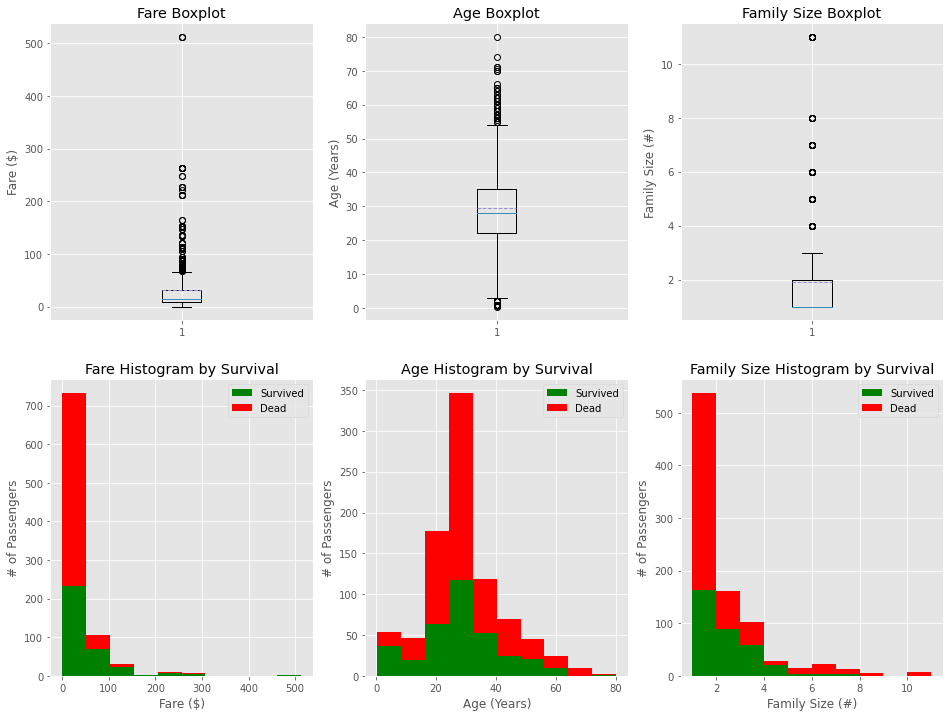

In [13]:
#IMPORTANT: Intentionally plotted different ways for learning purposes only. 

#optional plotting w/pandas: https://pandas.pydata.org/pandas-docs/stable/visualization.html

#we will use matplotlib.pyplot: https://matplotlib.org/api/pyplot_api.html

#to organize our graphics will use figure: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.figure.html#matplotlib.pyplot.figure
#subplot: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html#matplotlib.pyplot.subplot
#and subplotS: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html?highlight=matplotlib%20pyplot%20subplots#matplotlib.pyplot.subplots

#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=data1['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data1['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

In [14]:
dep_var = 'Survived'

In [15]:
cont_nn,cat_nn = cont_cat_split(data1[data1_x_bin], max_card=9000, dep_var=dep_var)

In [16]:
d = data1[data1_x_bin]
d['Survived'] = data1['Survived'].astype(np.float32)
d

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [17]:
cont_nn,cat_nn

([],
 ['Sex_Code',
  'Pclass',
  'Embarked_Code',
  'Title_Code',
  'FamilySize',
  'AgeBin_Code',
  'FareBin_Code'])

In [18]:
splits = RandomSplitter(valid_pct=0.2)(range_of(d))

In [19]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(d, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [20]:
len(to_nn.train),len(to_nn.valid)

(713, 178)

In [21]:
dls = to_nn.dataloaders()

In [22]:
y = to_nn.train
y

     Sex_Code  Pclass  Embarked_Code  Title_Code  FamilySize  AgeBin_Code  \
788         2       3              3           1           4            1   
525         2       3              2           4           1            3   
821         2       3              3           4           1            2   
253         2       3              3           4           2            2   
374         1       3              3           3           5            1   
..        ...     ...            ...         ...         ...          ...   
173         2       3              3           4           1            2   
462         2       1              3           4           1            3   
358         1       3              2           3           1            2   
532         2       3              1           4           3            2   
344         2       2              3           4           1            3   

     FareBin_Code  Survived  
788             3       1.0  
525            

In [23]:
learn1 = tabular_learner(dls, y_range=(0,1), loss_func=F.mse_loss,metrics=accuracy)

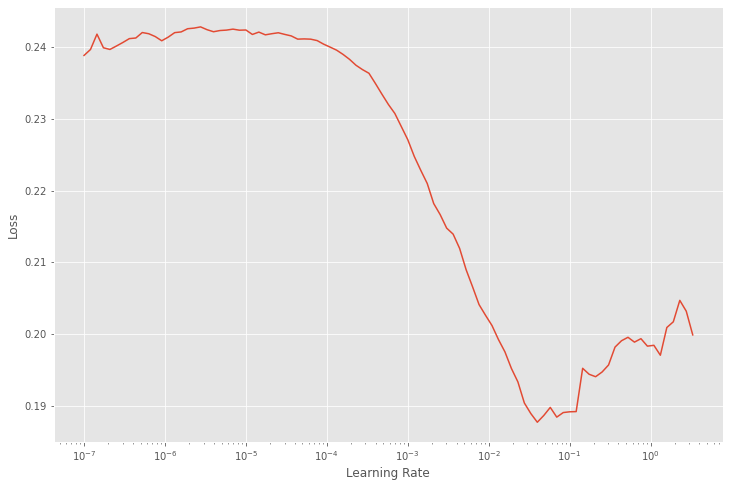

In [24]:
lrmin, lrsteep = learn1.lr_find()

In [25]:
learn1.fine_tune(7, lrsteep)

epoch,train_loss,valid_loss,accuracy,time
0,0.306646,0.387640,0.595506,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.372565,0.376404,0.595506,00:00
1,0.312484,0.297753,0.595506,00:00
2,0.293883,0.308989,0.595506,00:00
3,0.286930,0.325843,0.595506,00:00
4,0.283578,0.325843,0.595506,00:00
5,0.283524,0.308989,0.595506,00:00
6,0.282463,0.308989,0.595506,00:00


In [26]:
X_train, y_train = to_nn.train.xs, to_nn.train.ys.values.ravel()
X_valid, y_valid = to_nn.valid.xs, to_nn.valid.ys.values.ravel()

In [27]:
preds,targs = learn1.get_preds()
for i in range(len(preds)):
    if(preds[i] > 0.5):
        preds[i] = 1
    else:
        preds[i] = 0
        
accuracy_score(preds, targs)

0.6910112359550562

In [28]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True, metrics=accuracy).fit(xs, y)

In [29]:
rnf_classifier= RandomForestRegressor(n_jobs=-1, n_estimators=100)
rnf_classifier.fit(X_train,y_train)
y_pred=rnf_classifier.predict(X_valid)
for i in range(len(y_pred)):
    if(y_pred[i] > 0.5):
        y_pred[i] = 1
    else:
        y_pred[i] = 0

accuracy_score(y_pred, y_valid)


0.848314606741573

In [32]:
test = TabularPandas(df_test, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_nn,
                   cont_names = cont_nn,
                   )

In [33]:
X_test= test.train.xs

In [38]:
y_pred=rnf_classifier.predict(X_test)

In [39]:
for i in range(len(y_pred)):
    if(y_pred[i] > 0.5):
        y_pred[i] = 1
    else:
        y_pred[i] = 0

y_pred= y_pred.astype(int)
y_pred

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
     

In [40]:
output= pd.DataFrame({'PassengerId':df_test.PassengerId, 'Survived': y_pred})
output.to_csv('submission3_nar_titanic.csv', index=False)
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
